config : windows 10, python 3.9.3

In [808]:
!pip install opencv-python numpy mediapipe matplotlib

In [809]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

init

In [810]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,min_detection_confidence=0.3,model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

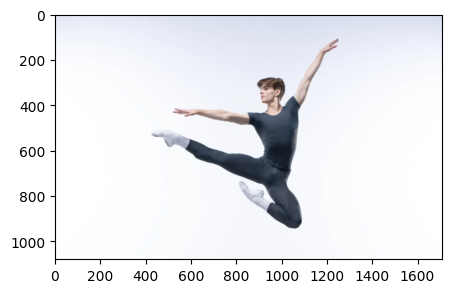

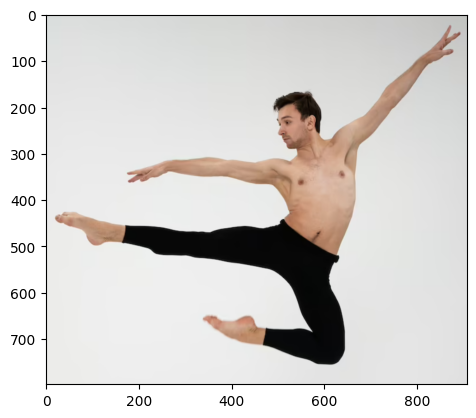

In [811]:
img = cv2.imread('media/ballerina1.png')
plt.figure(figsize=[5,5])
plt.imshow(img[:,:,::-1])
plt.show()

test_img = cv2.imread('media/ballerina2.png')
plt.imshow(test_img[:,:,::-1])
plt.show()

### Key Point Detection

In [812]:
results1 = pose.process(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
)  # converting image to rgb format
landmarks = []
if results1.pose_landmarks:
    for i in range(33):
        norm_landmark = results1.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]
        print(f"{mp_pose.PoseLandmark(i).name}:\n{norm_landmark}")
        landmarks.append(np.array([norm_landmark.x, norm_landmark.y, norm_landmark.z]))


NOSE:
x: 0.5330646634101868
y: 0.3216376304626465
z: -0.20817577838897705
visibility: 0.9999216794967651

LEFT_EYE_INNER:
x: 0.5409209132194519
y: 0.30628034472465515
z: -0.20080576837062836
visibility: 0.9997995495796204

LEFT_EYE:
x: 0.5440464615821838
y: 0.30587029457092285
z: -0.2011706382036209
visibility: 0.999822199344635

LEFT_EYE_OUTER:
x: 0.5467259287834167
y: 0.30584755539894104
z: -0.2011193484067917
visibility: 0.9998111128807068

RIGHT_EYE_INNER:
x: 0.5371752381324768
y: 0.30767303705215454
z: -0.1896980255842209
visibility: 0.9999030828475952

RIGHT_EYE:
x: 0.5371882915496826
y: 0.30848678946495056
z: -0.19021104276180267
visibility: 0.9999428987503052

RIGHT_EYE_OUTER:
x: 0.5369143486022949
y: 0.3092230558395386
z: -0.19040484726428986
visibility: 0.9999390840530396

LEFT_EAR:
x: 0.5636845231056213
y: 0.3153356909751892
z: -0.15572820603847504
visibility: 0.9999254941940308

RIGHT_EAR:
x: 0.5483656525611877
y: 0.3181230425834656
z: -0.10249905288219452
visibility: 0.999

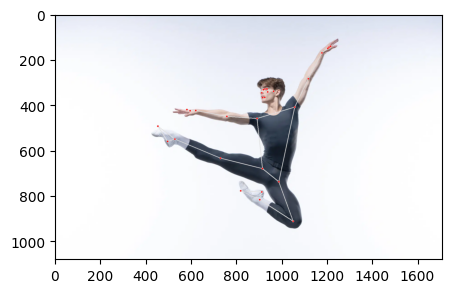

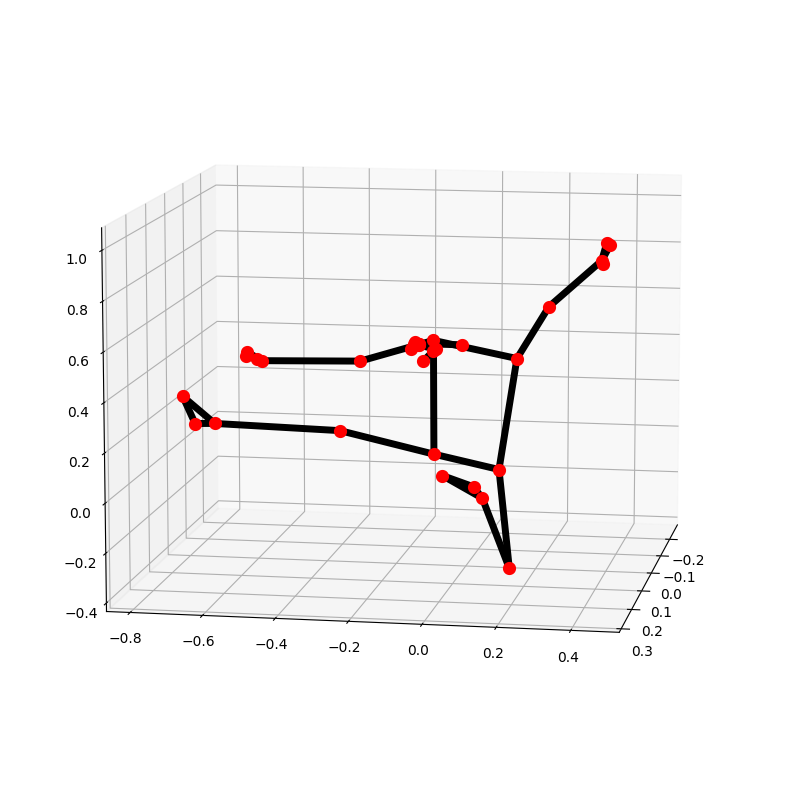

In [813]:
img_copy = img.copy()
if results1.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy,landmark_list=results1.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize=[5,5])
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

    # for 3d
    mp_drawing.plot_landmarks(results1.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

Angle calculation function:

In [814]:
def findAngle(p1:np.array, p2:np.array, p3:np.array):
    v1 = p1-p2
    v2 = p3-p2
    v1_mag,v2_mag = np.linalg.norm(v1), np.linalg.norm(v2)
    
    # if(v1_mag == 0 or v2_mag == 0): 
    #     print("trying to divide by zero prevented")
    #     return 0

    v1 = v1 / v1_mag; v2 = v2 / v2_mag
    return math.acos(v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2])  # v1.x * v2.x + v1.y * v2.y + v1.z * v2.z

each index is the vertex of and the value stored in that index is a dictionary of {2 arms each}:angle_btw_2armsAndVertex

In [815]:
# index value: vertex, value at each index : {{2,4}:2c, {2,5}:3c,}   or  {arms:angle,arms:angle,arms:angle...}
arms_and_angles = [None for _ in range(len(landmarks))] # {i:set() for i in range(len(landmarks))}


# connected points is a list where index:landmark point, value at each index:set of connected points to that landmark point
connected_points = [set() for _ in range(len(landmarks))]

gradient helper function to draw the colour gradient on the connectors of the keypoints : 

In [816]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Function to generate gradient colors interpolating between two colors
def get_gradient_color(colors, n):
    start_color, end_color = colors
    r = np.linspace(start_color[0], end_color[0], n)
    g = np.linspace(start_color[1], end_color[1], n)
    b = np.linspace(start_color[2], end_color[2], n)
    return list(zip(r, g, b))

def draw_gradient_line_3d(
    ax_thing, start, end, left_intensity, right_intensity, num_points=100
):
    # Generate points along the line in 3D space
    x = np.linspace(start[0], end[0], num_points)
    y = np.linspace(start[1], end[1], num_points)
    z = np.linspace(start[2], end[2], num_points)
    
    # red to green to red interpolation based on red intensity on both ends 
    colors = get_gradient_color(
        [(left_intensity, 1-left_intensity, 0), (0, 1, 0)],
        num_points // 2,
    ) + get_gradient_color(
        [(0,1,0), (right_intensity, 1-right_intensity, 0)], num_points // 2
    )
    points = np.column_stack([x, y, z])

    line = Line3DCollection(list(zip(points[:-1], points[1:])), colors=colors, linewidths=3,zorder= 2)

    # Add the line to the 3D plot
    ax_thing.add_collection3d(line)


## Modified version of inbuilt 3d plot function:

In [817]:
import dataclasses
from typing import List, Optional, Tuple
from mediapipe.framework.formats import landmark_pb2
import matplotlib as mpl

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)


@dataclasses.dataclass
class DrawingSpec:
    # Color for drawing the annotation. Default to the white color.
    color: Tuple[int, int, int] = WHITE_COLOR
    # Thickness for drawing the annotation. Default to 2 pixels.
    thickness: int = 2
    # Circle radius. Default to 2 pixels.
    circle_radius: int = 2


def _normalize_color(color):
    return tuple(v / 255.0 for v in color)


def custom_3d_plot_landmarks(
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: DrawingSpec = DrawingSpec(color=RED_COLOR, thickness=5),
    connection_drawing_spec: DrawingSpec = DrawingSpec(color=BLACK_COLOR, thickness=5),
    elevation: int = 10,
    azimuth: int = 10,
    fig_size=(10,10),
    font_size = 5
):
    if not landmark_list:
        return
    plt.figure(figsize=fig_size)
    ax = plt.axes(projection="3d")
    ax.view_init(elev=elevation, azim=azimuth)
    plotted_landmarks = {}

    # # # LOOPING THROUGH EACH LANDMARK

    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue

        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness,
            zorder=1,
        )

        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)

    if connections:
        num_landmarks = len(landmark_list.landmark)

        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]

            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                try:
                # add each other the other's 'connected points' set
                    # print(start_idx,end_idx,f"{'same!' if start_idx == end_idx else ''}")
                    connected_points[start_idx].add(end_idx)
                    connected_points[end_idx].add(start_idx)
                except IndexError as e:
                    print(e)
                    print("start_idx:",start_idx,"end_idx:",end_idx,f"len(connected_points):{len(connected_points)}")
    
    # now we got a set of connected points for each landmark, lets figure out the angles for every set of 3 connected points ( v ^ L \_ )

    print("looping through every point again to find the angle between every group of 3 linearly connected points")
    # print(landmarks)
    for vertex in range(len(connected_points)):
        points = list(connected_points[vertex])
        
        num_connections = len(points)
        if num_connections > 1:
            angles = []
            arms = []
            for i in range(num_connections-1):  #   starts from 0 and excludes the last index
                for j in range(i+1,num_connections):
                    try:
                        # print(landmarks[points[i]],landmarks[vertex],landmarks[points[j]])

                        angle = findAngle(landmarks[points[i]],landmarks[vertex],landmarks[points[j]])
                        angles.append(angle)
                        arms.append(frozenset({points[i],points[j]}))
                    except IndexError as e:
                        print(f"i:{i},j:{j},len(points):{len(points)},len(landmarks):{len(landmarks)},points[i]:{points[i]},points[j]:{points[j]}")
            arms_and_angles[vertex] = dict(zip(arms,angles)) # have to convert arms set to a frozenset because keys have to be of immutable type
    import random as rd
    if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.

        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]

                draw_gradient_line_3d(
                    ax_thing=ax,
                    start=[_ for _ in landmark_pair[0]],
                    end=[_ for _ in landmark_pair[1]],
                    left_intensity=0.5,
                    right_intensity=1,
                    num_points=100,
                )


    # print the keypoint names and number of angles associated with it
    for idx, pos in plotted_landmarks.items():
        label = mp_pose.PoseLandmark(idx).name
        ax.text(
            pos[0],
            pos[1],
            pos[2],
            s=f"{idx}."+label+":"+str((arms_and_angles[idx])) if arms_and_angles[idx] else label,
            fontsize=font_size,
            color="blue",
            zorder=5,
            zdir='y'
        )

    plt.show()

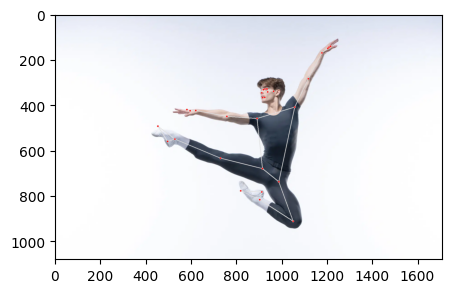

looping through every point again to find the angle between every group of 3 linearly connected points


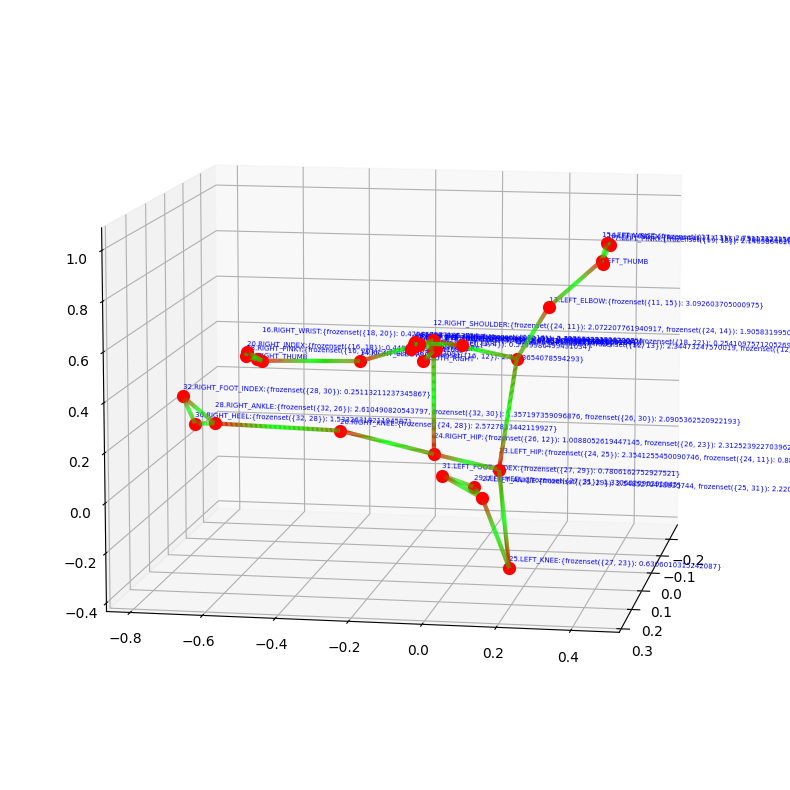

In [818]:
# display again to confirm:

img_copy = img.copy()
if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy,landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize=[5,5])
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

    # for 3d
    custom_3d_plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)